In [1]:
import json
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
# Connect to database
with open("config.json", "r") as f:
    config = json.load(f)

endpoint = config["endpoint"]
username = config["username"]
password = config["password"]
database_name = config["database_name"]


connection = pymysql.connect(host=endpoint, user=username, password=password, db=database_name)
cursor = connection.cursor()

In [3]:
# Runs queries to retrieve the data of a given table name. Converts it into a pandas DataFrame
def get_table(table_name):
    with connection.cursor() as cursor:
        # Get table data
        cursor.execute(f"SELECT * " 
                    f"FROM {table_name}")
        data = cursor.fetchall()

        # Get column names
        cursor.execute(f"SHOW COLUMNS "
                        f"FROM {table_name}")
        col_data = cursor.fetchall()
        cols = [col[0] for col in col_data]
        
        # Save to dataframe
        df = pd.DataFrame(data, columns=cols)
    return df

In [4]:
# Removes duplicate rows from the dataframe
def remove_duplicates(df):
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)

In [5]:
# Removes data that is out of range of the gym's hours. Removes data that was mistakenly added when the gym was closed
def remove_hours(df):
    df = df[
        (((df.Weekday_Word == 'Monday') | (df.Weekday_Word == 'Tuesday') | (df.Weekday_Word == 'Wednesday') | (df.Weekday_Word == 'Thursday')) # Monday-Thursday
        & (df.Hour >= 6) & (df.Hour < 24)) | # Monday-Thursday
        ((df.Weekday_Word == 'Friday') & (df.Hour >= 6) & (df.Hour < 22)) | # Friday
        ((df.Weekday_Word == 'Saturday') & (df.Hour >= 8) & (df.Hour < 22)) | # Saturday
        ((df.Weekday_Word == 'Sunday') & (df.Hour >= 8) & (df.Hour < 24)) # Sunday
    ]

In [6]:
# Calls all functions related to cleaning the data
def clean_data(df):
    remove_duplicates(df)
    remove_hours(df)

In [7]:
# Adds dates to the dataframe (I forgot to add them to the database when I made it)
def add_dates(df):
    day = datetime.datetime(year=2022, month=10, day=30)
    week_day = 'Sunday'
    days = []

    for index, row in df.iterrows():
        if week_day != row.Weekday_Word:
            week_day = row.Weekday_Word
            day += datetime.timedelta(days=1)

        days.append(day)
    df["Date"] = days

In [8]:
# Returns a fully processed dataframe
def get_df(table_name):
    df = get_table(table_name)
    clean_data(df)
    add_dates(df)
    
    return df

In [9]:
# Gets the left and right indecies (alternating in a 1-D list) of a dataframe for a certain day of the week
def get_index_list(weekday, df):
    index_list = []
    prev = None

    for index, row in df.iterrows():
        if row.Weekday_Word == weekday and row.Weekday_Word != prev:
            index_list.append(index)
        if row.Weekday_Word != prev and prev == weekday:
            index_list.append(index - 1)

        prev = row.Weekday_Word
    
    return index_list

In [10]:
# Uses the index_list to cerate a dataframe containing only rows of a certain day
def get_day_df(weekday, df):
    index_list = get_index_list(weekday, df)

    day_df = df.loc[index_list[0]:index_list[1]]
    for i in range(3, len(index_list), 2):
        l, r = index_list[i-1], index_list[i]
        day_df = pd.concat([day_df, df.loc[l:r]])

    return day_df

In [16]:
# Creates a dataframe that calculates the average population of each hour
def get_average_df(df, weekday=None, entire_week=False):
    if weekday is not None:
        day_df = get_day_df(weekday, df)
    elif entire_week:
        day_df = df
    else:
        return -1

    averages = None
    for i in range(25):
        hour_df = day_df.groupby(day_df.Hour == i).mean(numeric_only=True)

        if True in hour_df.index:
            pop = hour_df.loc[True].Population

            average = pd.DataFrame.from_dict({'Hour': [i], 'Population': [pop]})

            try:
                averages = pd.concat([averages, average])

            except:
                averages = average 
                
    return averages

In [12]:
# Plots 8 figures (Overall and 1 for each day of the week) of a given table name
def plot_table(table_name):
    df = get_df(table_name)

    m, n = 4, 2
    fig, axes = plt.subplots(m, n)

    days = ['Overall', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    for i in range(m):
        for j in range(n):
            if (n * i + j) >= len(days):
                break

            ax = axes[i][j]
            weekday = days[n * i + j]

            if weekday == 'Overall':
                averages = get_average_df(df, entire_week=True)
                color = 'red'
            else:
                averages = get_average_df(df, weekday)  
                color = 'black' 
            ax.plot(averages.Hour, averages.Population, color=color)

            # Plot
            ax.set_title(weekday)
            ax.set_xlabel('Hour')

            if weekday in ['Monday', 'Tuesday', 'Wednesday', 'Thursday']:
                ax.set_xbound(6, 24)
            elif weekday == 'Friday':
                ax.set_xbound(6, 22)
            elif weekday == 'Saturday':
                ax.set_xbound(8, 22)
            else:
                ax.set_xbound(8, 24)

            ax.set_ylabel('Population')
            
            
    fig.suptitle(table_name, fontsize=20)    
    fig.set_size_inches(10, 10)
    fig.tight_layout()
    plt.show()

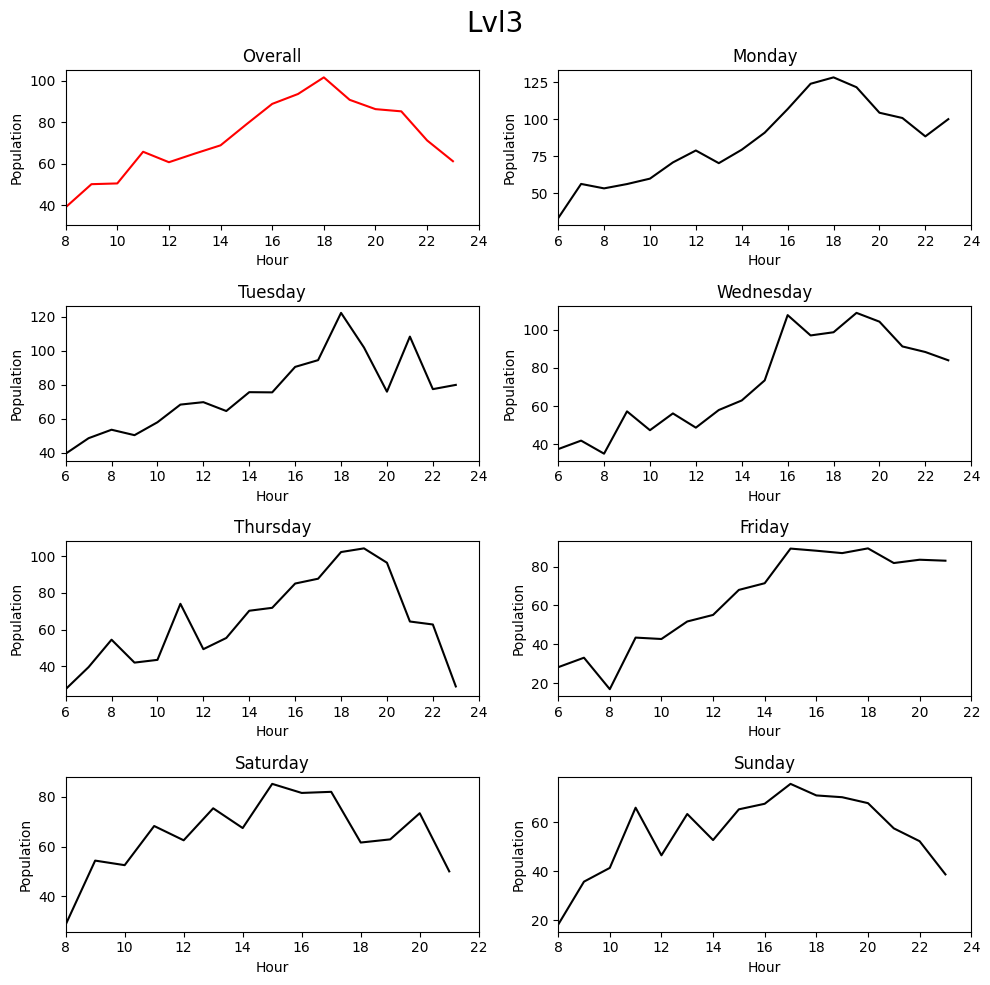

In [17]:
plot_table("Lvl3")